In [16]:
import os
import re
import subprocess
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import colormaps
from scipy import stats

from mri_data import file_manager as fm

sys.path.append("/home/srs-9/Projects/ms_mri/analysis/paper1")

import helpers

### Paths and Config

In [17]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
cp_data_dir = Path("/home/srs-9/Projects/ms_mri/analysis/paper1/data0")
dataroot = Path("/media/smbshare/srs-9/thalamus_project/data")

showfigs = False
pd.options.display.precision = 3
subject_sessions = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/subject-sessions.csv", index_col="sub")

viridis = colormaps['viridis'].resampled(20)

In [18]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")


new_index = []
for col in df_thomas.columns:
    new_index.append(int(re.match(r".+_(\d+)$", col)[1]))

df_structs = pd.DataFrame({'struct': df_thomas.columns}, index=new_index)
ind_struct_lookup = {}
for i, row in df_structs.iterrows():
    ind_struct_lookup[i] = row['struct']
struct_ind_lookup = {}
for i, row in df_structs.iterrows():
    struct_ind_lookup[row['struct']] = i

thalamic_nuclei = df_thomas.columns[1:11]
thalamic_nuclei_inds = [struct_ind_lookup[struct] for struct in thalamic_nuclei]

In [19]:
tmp_df = pd.DataFrame({"struct": df_thomas.columns}, index=new_index)
tmp_df.index.name = "index"
tmp_df.to_csv("hipsthomas_struct_index.csv")

In [30]:
df_dists = pd.read_csv(data_dir / "centroid-SDT.csv", index_col="subid")
ventricle_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/choroid_thalamus_project/sub1001-centroid-ventricle-sdt.csv")
df_dists.loc[9999, :] = ventricle_dists['dist'].tolist()

dist_colnames = {}
for k,v in ind_struct_lookup.items():
    dist_colnames[str(k)] = f"{v}_dist"
df_dists = df_dists.rename(columns=dist_colnames)
df_dists_z = df_dists.apply(stats.zscore, nan_policy="omit")

In [47]:
df = pd.read_csv(cp_data_dir / "t1_aschoplex_data_full.csv", index_col="subid")
df_full = df.copy()
df_tmp = pd.read_csv(cp_data_dir / "t1_data_full.csv", index_col="subid")
df['pineal_volume'] = df_tmp['pineal_volume']
df['pituitary_volume'] = df_tmp['pituitary_volume']
# df = pd.concat((df, pd.get_dummies(df["sex"], dtype="int")), axis=1)
df = helpers.set_dz_type5(df)
df = helpers.fix_edss(df)
df = df.rename(columns={"extracted_EDSS": "EDSS"})
df = df.rename(columns={"lesion_vol_cubic": "t2lv"})
df = helpers.do_sqrt_transform(df, ["EDSS"])
df = helpers.do_sqrt_transform(df, ["t2lv"])

df = helpers.clean_df(df)
df['dzdur'] = df['dzdur'].astype("float")
numeric_vars = ["choroid_volume", "pineal_volume", "pituitary_volume", "Female", "age", "tiv", "EDSS", "EDSS_sqrt", "t2lv", "t2lv_sqrt", "dzdur", "thalamus"]
keep_cols = numeric_vars + ["dz_type5", "ms_type"]
df = df[keep_cols]
df_z = df.copy()
df_z[numeric_vars] = df_z[numeric_vars].apply(stats.zscore, nan_policy="omit")

Outcome: choroid

thalamic nuclei

      struct   coef      pvals     se  p_fdr  coef_sig
11     CM_11 -0.312  9.697e-04  0.093  0.010    -0.312
2       AV_2 -0.295  1.208e-02  0.109  0.032    -0.295
8      Pul_8 -0.278  1.940e-03  0.090  0.010    -0.278
12  MD_Pf_12 -0.214  1.276e-02  0.091  0.032    -0.214
6      VLP_6 -0.210  1.983e-02  0.074  0.040    -0.210
7      VPL_7 -0.198  2.991e-02  0.075  0.050    -0.198
10    MGN_10 -0.193  4.015e-02  0.086  0.057     0.000
4       VA_4 -0.188  1.174e-01  0.095  0.130     0.000
9      LGN_9 -0.172  7.235e-02  0.085  0.090     0.000
5      VLa_5 -0.145  1.644e-01  0.091  0.164     0.000


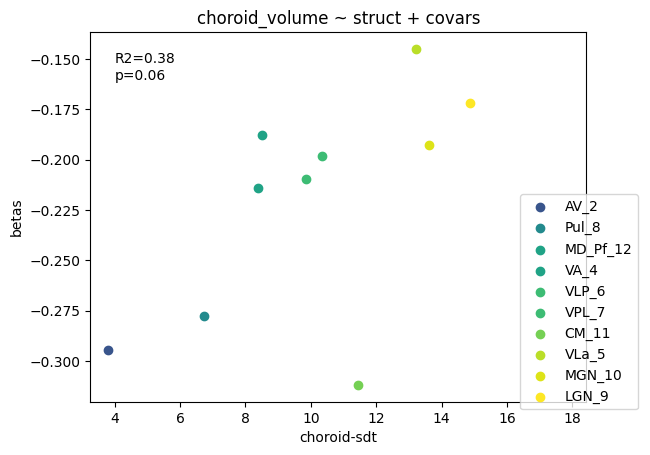

In [74]:
model_data = df_z.join([df_thomas_z, df_dists_z])
model_data = model_data[model_data['dz_type5'].isin(["PMS"])]
# model_data = model_data[model_data['ms_type'].isin(["SPMS"])]
# subjects = [1001, 1107, 1125, 1161, 1198, 1218, 1326, 1527, 2195, 1376, 2075, 1023, 1038, 1098]
# model_data = model_data.loc[subjects, :]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
se = {}

outcome = "choroid_volume"

structs = thalamic_nuclei
# structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
# structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28", "RN_32", "Put_31", "Acc_26"])]
all_results = {}
for struct in structs:
    formula = f"{outcome} ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]
    se[struct] = res.HC0_se[struct]
    all_results[struct] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

print(regression_results)

df_summary = regression_results.copy()
for i in df_summary.index:
    df_summary.loc[i, 'dist'] = df_dists[f"{ind_struct_lookup[i]}_dist"].mean()
    # df_summary.loc[i, 'dist'] = df_dists.loc[9999, f"{ind_struct_lookup[i]}_dist"]


df_summary = df_summary.sort_values(by="dist")
fig, axes = plt.subplots(1)
for i, row in df_summary.iterrows():
    c = df_summary.loc[i, 'dist'] / df_summary['dist'].max()
    axes.scatter(df_summary.loc[i, 'dist'], df_summary.loc[i, 'coef'], color=viridis(c), label=df_summary.loc[i, 'struct'])


xlims = axes.get_xlim()
axes.set_xbound([xlims[0], xlims[1]+3])
fig.legend(loc=(0.8,0.1))

slope, intercept, r_value, p_value, std_err = stats.linregress(df_summary['dist'], df_summary['coef'])

text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
axes.text(4, -0.16, text)

axes.set_xlabel("choroid-sdt")
axes.set_ylabel("betas")
axes.set_title("choroid_volume ~ struct + covars")

plt.savefig("thalamic_nuclei_PMS.png", dpi=300, pad_inches=0.2)

In [37]:
regression_results.sort_index(inplace=True)
print(regression_results['coef'].tolist())

[-0.26376534513472844, -0.10892236831978641, -0.09645562979630193, -0.25948453700171425, -0.2640217464289075, -0.4497696601508273, -0.3397940232636508, -0.38804827139841236, -0.402351467530654, -0.44933435065192123]


In [73]:
model_data = df_z.join([df_thomas_norm_z, df_dists_z])
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]

formula = "Pul_8 ~ choroid_volume*Pul_8_dist + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Pul_8   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     12.48
Date:                Wed, 07 May 2025   Prob (F-statistic):           6.50e-13
Time:                        18:26:37   Log-Likelihood:                -547.49
No. Observations:                 409   AIC:                             1109.
Df Residuals:                     402   BIC:                             1137.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [184]:
sub = 1001
subdir = dataroot / f"sub{sub}-{subject_sessions.loc[sub, 'ses']}"
thomL_img = nib.load(subdir / "thomasfull_L.nii.gz")
affine = thomL_img.affine
thomL = thomL_img.get_fdata()
thomR = nib.load(subdir / "thomasfull_R.nii.gz").get_fdata()
thom = thomL + thomR

thom[~np.isin(thom, regression_results.index)] = 0
for i, row in regression_results.iterrows():
    thom[thom==i] = row['coef']

thom_img = nib.Nifti1Image(thom, affine)
nib.save(thom_img, subdir/"thalamic_nuclei-choroid_betamap.nii.gz")

In [ ]:
save_dir = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/screenshots/1001-thalamic_nuclei-choroid_betamap1")
x = 181
y = 168
t1 = "/media/smbshare/srs-9/thalamus_project/data/sub1001-20170215/t1.nii.gz"
overlay = "/media/smbshare/srs-9/thalamus_project/data/sub1001-20170215/thalamic_nuclei-choroid_betamap.nii.gz"

script = "/home/srs-9/Projects/ms_mri/analysis/thalamus/screenshot_script.sh"


for i in range(160, 188, 2):
    savepath = save_dir / f"slice{i}.jpg"
    cmd = ["bash", script, str(i), str(savepath)]
    subprocess.run(cmd)

Outcome EDSS

Thalamic nuclei

Text(0.5, 1.0, 'EDSS ~ struct + covars')

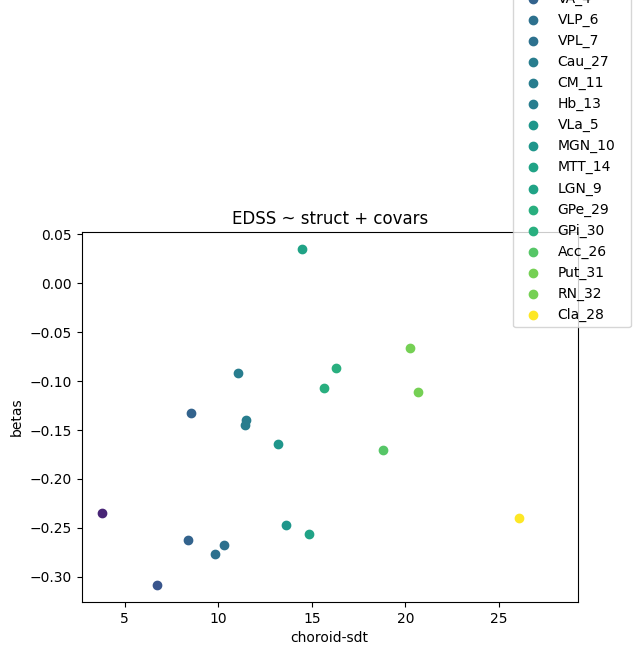

In [11]:
model_data = df_z.join([df_thomas_z, df_dists_z])
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

outcome = "EDSS"

structs = thalamic_nuclei
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
all_results = {}
for struct in structs:
    formula = f"{outcome} ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]
    all_results[struct] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

# print(regression_results)

df_summary = regression_results.copy()
for i in df_summary.index:
    df_summary.loc[i, 'dist'] = df_dists[f"{ind_struct_lookup[i]}_dist"].mean()


df_summary = df_summary.sort_values(by="dist")
fig, axes = plt.subplots(1)
for i, row in df_summary.iterrows():
    c = df_summary.loc[i, 'dist'] / df_summary['dist'].max()
    axes.scatter(df_summary.loc[i, 'dist'], df_summary.loc[i, 'coef'], color=viridis(c), label=df_summary.loc[i, 'struct'])


xlims = axes.get_xlim()
axes.set_xbound([xlims[0], xlims[1]+2])
fig.legend(loc=(0.8,0.5))


axes.set_xlabel("choroid-sdt")
axes.set_ylabel("betas")
axes.set_title("EDSS ~ struct + covars")

Outcome: EDSS  

All structures

Text(4, 0, 'R2=0.20\np=0.06')

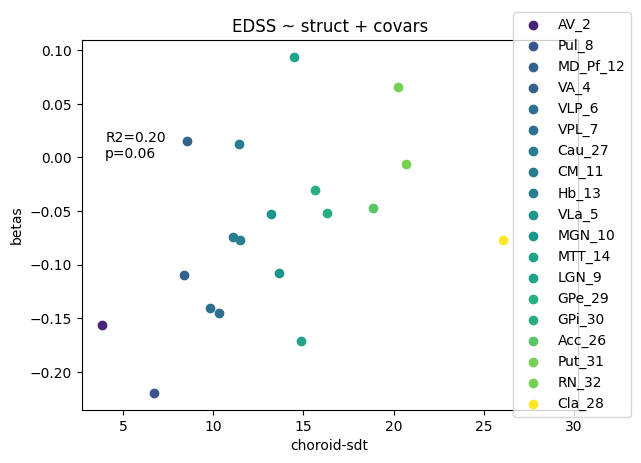

In [14]:
model_data = df_z.join([df_thomas_z, df_dists_z])
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv + thalamus"

pvals = {}
coefs = {}

outcome = "EDSS_sqrt"

# structs = thalamic_nuclei
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "CLa_28"])]
all_results = {}
for struct in structs:
    formula = f"{outcome} ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]
    all_results[struct] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

# print(regression_results)

df_summary = regression_results.copy()
# df_summary = df_summary[df_summary['p_fdr'] < 0.05]
for i in df_summary.index:
    df_summary.loc[i, 'dist'] = df_dists[f"{ind_struct_lookup[i]}_dist"].mean()


df_summary = df_summary.sort_values(by="dist")
fig, axes = plt.subplots(1)
for i, row in df_summary.iterrows():
    c = df_summary.loc[i, 'dist'] / df_summary['dist'].max()
    axes.scatter(df_summary.loc[i, 'dist'], df_summary.loc[i, 'coef'], color=viridis(c), label=df_summary.loc[i, 'struct'])

axes.set_xlabel("choroid-sdt")
axes.set_ylabel("betas")
axes.set_title("EDSS ~ struct + covars")

xlims = axes.get_xlim()
axes.set_xbound([xlims[0], xlims[1]+3])

fig.legend(loc=(0.8,0.1))

slope, intercept, r_value, p_value, std_err = stats.linregress(df_summary['dist'], df_summary['coef'])

text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
axes.text(4, 0, text)

In [200]:
print(regression_results)

      struct   coef      pvals      p_fdr  coef_sig
8      Pul_8 -0.295  4.118e-09  7.824e-08    -0.295
6      VLP_6 -0.271  6.138e-07  2.332e-06    -0.271
7      VPL_7 -0.260  4.301e-07  2.332e-06    -0.260
9      LGN_9 -0.254  7.704e-08  7.319e-07    -0.254
2       AV_2 -0.252  2.272e-06  7.193e-06    -0.252
12  MD_Pf_12 -0.251  5.764e-07  2.332e-06    -0.251
10    MGN_10 -0.224  2.221e-05  6.027e-05    -0.224
28    Cla_28 -0.208  1.635e-04  3.884e-04    -0.208
5      VLa_5 -0.175  2.093e-03  4.419e-03    -0.175
26    Acc_26 -0.158  4.197e-03  7.974e-03    -0.158
4       VA_4 -0.142  1.601e-02  2.339e-02    -0.142
11     CM_11 -0.136  1.052e-02  1.665e-02    -0.136
13     Hb_13 -0.132  4.908e-03  8.478e-03    -0.132
32     RN_32 -0.123  3.499e-02  4.748e-02    -0.123
27    Cau_27 -0.109  5.109e-02  6.472e-02     0.000
29    GPe_29 -0.089  1.300e-01  1.544e-01     0.000
30    GPi_30 -0.084  1.435e-01  1.603e-01     0.000
31    Put_31 -0.063  2.937e-01  3.100e-01     0.000
14    MTT_14

In [198]:
sub = 1001
subdir = dataroot / f"sub{sub}-{subject_sessions.loc[sub, 'ses']}"
thomL_img = nib.load(subdir / "thomasfull_L.nii.gz")
affine = thomL_img.affine
thomL = thomL_img.get_fdata()
thomR = nib.load(subdir / "thomasfull_R.nii.gz").get_fdata()
thom = thomL + thomR

thom[~np.isin(thom, regression_results.index)] = 0
for i, row in regression_results.iterrows():
    thom[thom==i] = row['coef']

thom_img = nib.Nifti1Image(thom, affine)
nib.save(thom_img, subdir/"hiptsthomas-edss_betamap.nii.gz")

In [205]:
save_dir = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/screenshots/1001-hipsthomas-edss_betamap1")
script = "/home/srs-9/Projects/ms_mri/analysis/thalamus/screenshot_script.sh"

for i in range(158, 192, 2):
    savepath = save_dir / f"slice{i}.jpg"
    cmd = ["bash", script, str(i), str(savepath)]
    subprocess.run(cmd)

niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRea

Outcome: EDSS  

All structures except claustrum

      struct   coef      pvals      p_fdr  coef_sig
8      Pul_8 -0.288  1.896e-10  4.875e-10    -0.288
9      LGN_9 -0.145  1.059e-03  1.589e-03    -0.145
2       AV_2 -0.125  1.297e-02  1.795e-02    -0.125
12  MD_Pf_12 -0.102  1.933e-02  2.485e-02    -0.102
11     CM_11  0.004  9.320e-01  9.320e-01     0.000
13     Hb_13  0.055  2.211e-01  2.341e-01     0.000
10    MGN_10  0.081  9.291e-02  1.045e-01     0.000
7      VPL_7  0.091  4.112e-02  4.934e-02     0.091
26    Acc_26  0.179  9.890e-05  1.618e-04     0.179
27    Cau_27  0.274  3.384e-09  6.091e-09     0.274
31    Put_31  0.284  2.157e-09  4.314e-09     0.284
32     RN_32  0.289  1.460e-09  3.286e-09     0.289
6      VLP_6  0.304  5.362e-11  1.609e-10     0.304
14    MTT_14  0.317  4.282e-11  1.542e-10     0.317
29    GPe_29  0.324  3.753e-11  1.542e-10     0.324
30    GPi_30  0.354  1.430e-11  8.578e-11     0.354
5      VLa_5  0.364  2.212e-15  1.991e-14     0.364
4       VA_4  0.394  1.105e-17  1.989e-16     0.394


Text(4, 0, 'R2=0.25\np=0.03')

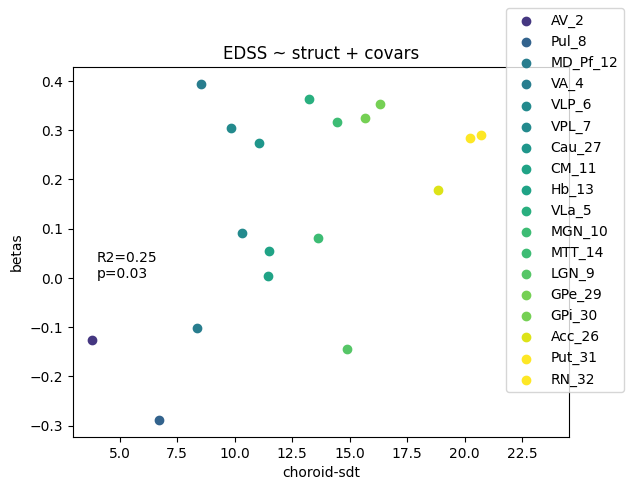

In [65]:
model_data = df_z.join([df_thomas_norm_z, df_dists_z])
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

outcome = "choroid_volume"

# structs = thalamic_nuclei
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
all_results = {}
for struct in structs:
    formula = f"{outcome} ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]
    all_results[struct] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

print(regression_results)

df_summary = regression_results.copy()
# df_summary = df_summary[df_summary['p_fdr'] < 0.05]
for i in df_summary.index:
    df_summary.loc[i, 'dist'] = df_dists[f"{ind_struct_lookup[i]}_dist"].mean()


df_summary = df_summary.sort_values(by="dist")
fig, axes = plt.subplots(1)
for i, row in df_summary.iterrows():
    c = df_summary.loc[i, 'dist'] / df_summary['dist'].max()
    axes.scatter(df_summary.loc[i, 'dist'], df_summary.loc[i, 'coef'], color=viridis(c), label=df_summary.loc[i, 'struct'])

axes.set_xlabel("choroid-sdt")
axes.set_ylabel("betas")
axes.set_title("EDSS ~ struct + covars")

xlims = axes.get_xlim()
axes.set_xbound([xlims[0], xlims[1]+3])

fig.legend(loc=(0.8,0.2))

slope, intercept, r_value, p_value, std_err = stats.linregress(df_summary['dist'], df_summary['coef'])

text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
axes.text(4, 0, text)

In [96]:
model_data = df_z.join([df_thomas_z, df_dists_z])
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

# structs = thalamic_nuclei
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
all_results = {}
for struct in structs:
    formula = f"{struct} ~ EDSS_sqrt + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues['EDSS_sqrt']
    coefs[struct] = res.params['EDSS_sqrt']
    all_results[struct] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

print(regression_results)

      struct   coef      pvals      p_fdr  coef_sig
8      Pul_8 -0.286  4.118e-09  7.824e-08    -0.286
9      LGN_9 -0.280  7.704e-08  7.319e-07    -0.280
12  MD_Pf_12 -0.246  5.764e-07  2.332e-06    -0.246
7      VPL_7 -0.243  4.301e-07  2.332e-06    -0.243
6      VLP_6 -0.227  6.138e-07  2.332e-06    -0.227
2       AV_2 -0.220  2.272e-06  7.193e-06    -0.220
10    MGN_10 -0.200  2.221e-05  6.027e-05    -0.200
28    Cla_28 -0.171  1.635e-04  3.884e-04    -0.171
13     Hb_13 -0.152  4.908e-03  8.478e-03    -0.152
5      VLa_5 -0.137  2.093e-03  4.419e-03    -0.137
26    Acc_26 -0.132  4.197e-03  7.974e-03    -0.132
11     CM_11 -0.122  1.052e-02  1.665e-02    -0.122
4       VA_4 -0.104  1.601e-02  2.339e-02    -0.104
32     RN_32 -0.092  3.499e-02  4.748e-02    -0.092
27    Cau_27 -0.089  5.109e-02  6.472e-02     0.000
29    GPe_29 -0.066  1.300e-01  1.544e-01     0.000
30    GPi_30 -0.065  1.435e-01  1.603e-01     0.000
31    Put_31 -0.045  2.937e-01  3.100e-01     0.000
14    MTT_14

In [109]:
df_summary = regression_results.copy()
for i in df_summary.index:
    df_summary.loc[i, 'dist'] = df_dists[f"{ind_struct_lookup[i]}_dist"].mean()

df_summary['colors'] = list(np.random.choice(range(256), size=(len(df_summary), 3)) / 255)

/tmp/ipykernel_700599/341764750.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes.scatter(df_summary.loc[i, 'dist'], df_summary.loc[i, 'coef'], c=viridis(c), label=df_summary.loc[i, 'struct'])


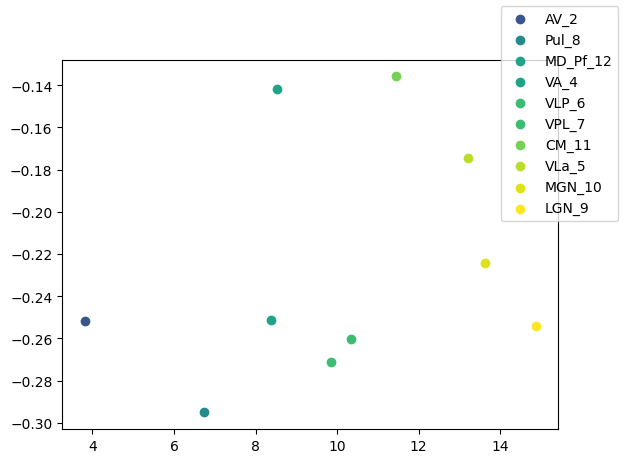

In [110]:
viridis = colormaps['viridis'].resampled(20)
df_summary = df_summary.sort_values(by="dist")
fig, axes = plt.subplots(1)
for i, row in df_summary.iterrows():
    c = df_summary.loc[i, 'dist'] / df_summary['dist'].max()
    axes.scatter(df_summary.loc[i, 'dist'], df_summary.loc[i, 'coef'], c=viridis(c), label=df_summary.loc[i, 'struct'])
fig.legend(loc='outside upper right')

In [75]:
sub = 1001
subdir = dataroot / f"sub{sub}-{subject_sessions.loc[sub, 'ses']}"
thomL_img = nib.load(subdir / "thomasfull_L.nii.gz")
affine = thomL_img.affine
thomL = thomL_img.get_fdata()
thomR = nib.load(subdir / "thomasfull_R.nii.gz").get_fdata()
thom = thomL + thomR
thom[~np.isin(thom, thalamic_nuclei_inds)] = 0
for struct in thalamic_nuclei:
    colname = struct + "_dist"
    dist = df_dists.loc[sub, colname]
    i = struct_ind_lookup[struct]
    thom[thom==i] = dist

thom_img = nib.Nifti1Image(thom, affine)
nib.save(thom_img, subdir/"thalamic_nuclei-choroid_sdt-map.nii.gz")

In [181]:
sub = 1001
subdir = dataroot / f"sub{sub}-{subject_sessions.loc[sub, 'ses']}"
thomL_img = nib.load(subdir / "thomasfull_L.nii.gz")
affine = thomL_img.affine
thomL = thomL_img.get_fdata()
thomR = nib.load(subdir / "thomasfull_R.nii.gz").get_fdata()
thom = thomL + thomR
for colname in df_dists.columns:
    dist = df_dists.loc[sub, colname]
    struct = re.sub("_dist", "", colname)
    i = struct_ind_lookup[struct]
    thom[thom==i] = dist

thom_img = nib.Nifti1Image(thom, affine)
nib.save(thom_img, subdir/"hipsthomas-choroid_sdt-map.nii.gz")